In [3]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
# [1] Imports e setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

# Função de métricas
def calc_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


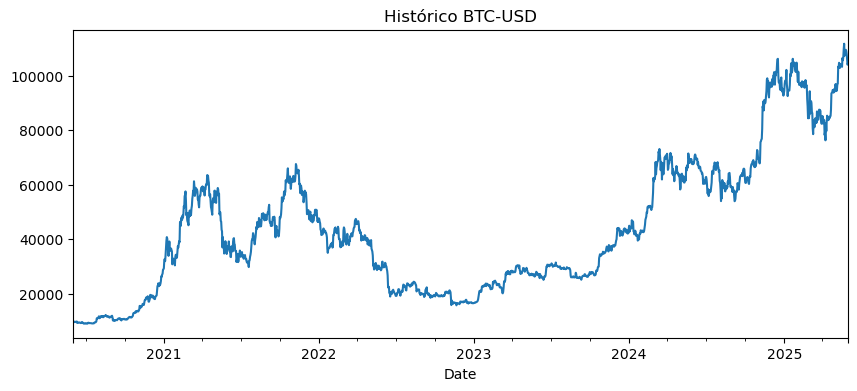

In [5]:
# [2] Carregar dataset
# Assumindo que já temos df com colunas ['Date','Close']
df = pd.read_csv('data/btc_limpo.csv')  # ajuste o caminho
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date','Close']].dropna()

# Plot inicial
df.set_index('Date')['Close'].plot(title='Histórico BTC-USD', figsize=(10,4))
plt.show()


In [6]:
# [3] Preparar dados Prophet
df_prophet = df.rename(columns={'Date':'ds','Close':'y'})
df_prophet.tail()


,ds,y
1821,2025-05-27,108994.640625
1822,2025-05-28,107802.328125
1823,2025-05-29,105641.757812
1824,2025-05-30,103998.570312
1825,2025-05-31,104638.093750


In [7]:
# [3] Preparar dados Prophet
df_prophet = df.rename(columns={'Date':'ds','Close':'y'})
df_prophet.tail()


,ds,y
1821,2025-05-27,108994.640625
1822,2025-05-28,107802.328125
1823,2025-05-29,105641.757812
1824,2025-05-30,103998.570312
1825,2025-05-31,104638.093750


19:16:42 - cmdstanpy - INFO - Chain [1] start processing
19:16:43 - cmdstanpy - INFO - Chain [1] done processing


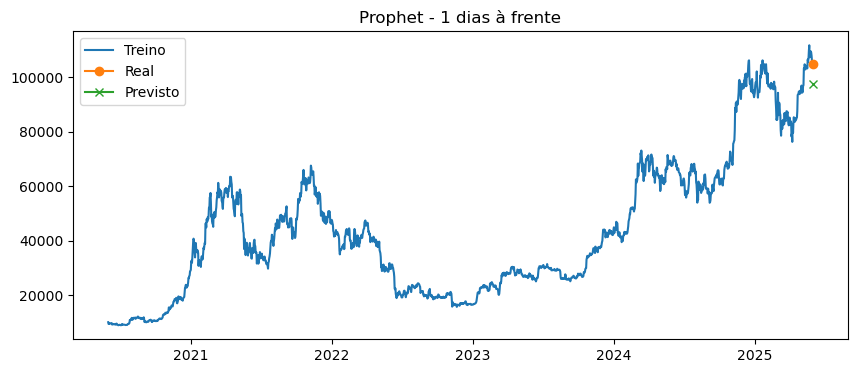

19:16:44 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing


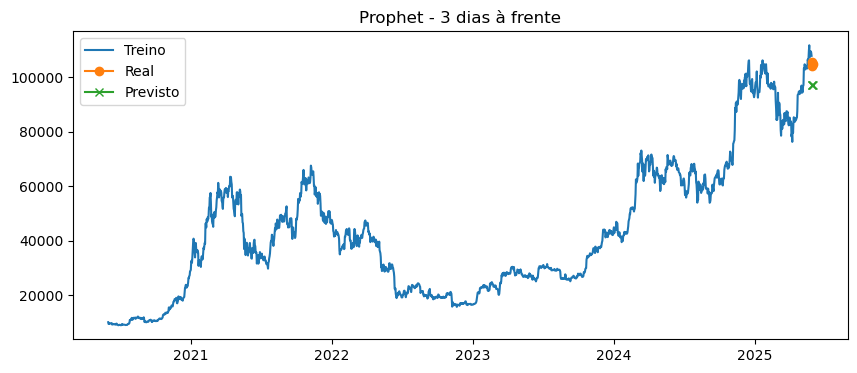

19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing


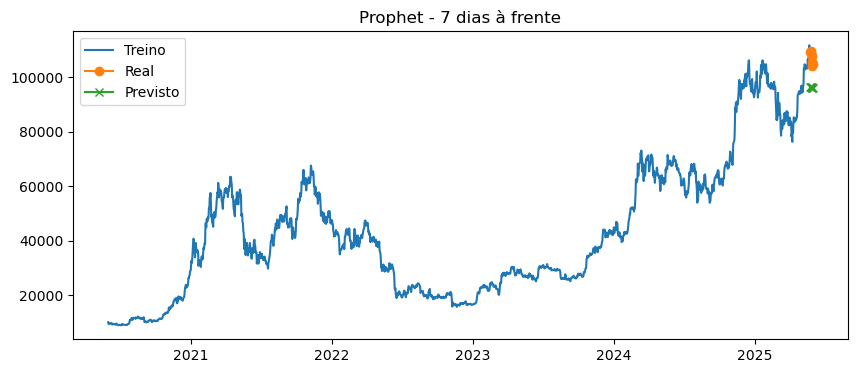

[(1,
  {'MAE': 7198.381290746678,
   'RMSE': np.float64(7198.381290746678),
   'MAPE': np.float64(6.879312335281029)}),
 (3,
  {'MAE': 7560.350390588617,
   'RMSE': np.float64(7587.518354913327),
   'MAPE': np.float64(7.213239857235827)}),
 (7,
  {'MAE': 10824.860723365953,
   'RMSE': np.float64(10994.32556620667),
   'MAPE': np.float64(10.077653077511165)})]

In [8]:
# [4] Prophet — Previsões multi-step
horizons = [1,3,7]
prophet_results = []

for h in horizons:
    # Treino até o penúltimo horizonte
    train = df_prophet.iloc[:-h]
    test  = df_prophet.iloc[-h:]

    model = Prophet(daily_seasonality=True)
    model.fit(train)

    future = model.make_future_dataframe(periods=h)
    forecast = model.predict(future)

    y_pred = forecast[['ds','yhat']].iloc[-h:]['yhat'].values
    y_true = test['y'].values

    metrics = calc_metrics(y_true, y_pred)
    prophet_results.append((h, metrics))

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train['ds'], train['y'], label='Treino')
    plt.plot(test['ds'], y_true, label='Real', marker='o')
    plt.plot(test['ds'], y_pred, label='Previsto', marker='x')
    plt.title(f'Prophet - {h} dias à frente')
    plt.legend()
    plt.show()

prophet_results


In [9]:
# [5] Preparar dados para LSTM
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close']])

def make_supervised(data, n_lags=30, horizon=1):
    X, y = [], []
    for i in range(len(data) - n_lags - horizon):
        X.append(data[i:i+n_lags])
        y.append(data[i+n_lags+horizon-1])
    return np.array(X), np.array(y)

X_all, y_all = make_supervised(scaled, n_lags=30, horizon=1)


In [11]:
# [6] Função LSTM para diferentes horizontes
def train_lstm(data, n_lags=30, horizon=1, epochs=10):
    X, y = make_supervised(data, n_lags, horizon)
    split = int(len(X)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_lags,1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    return y_test, y_pred


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step 


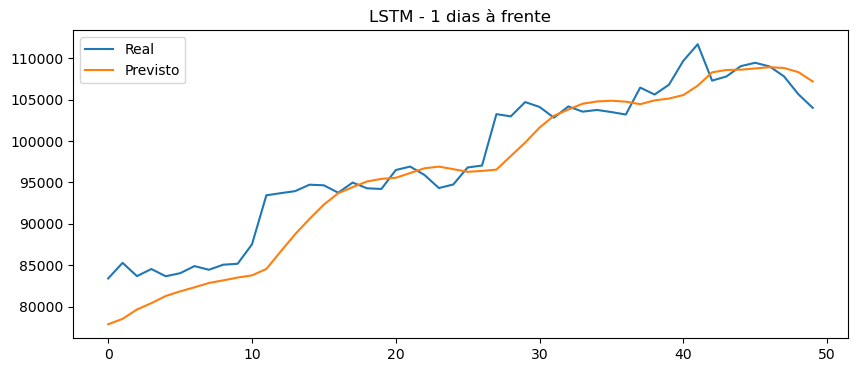

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 


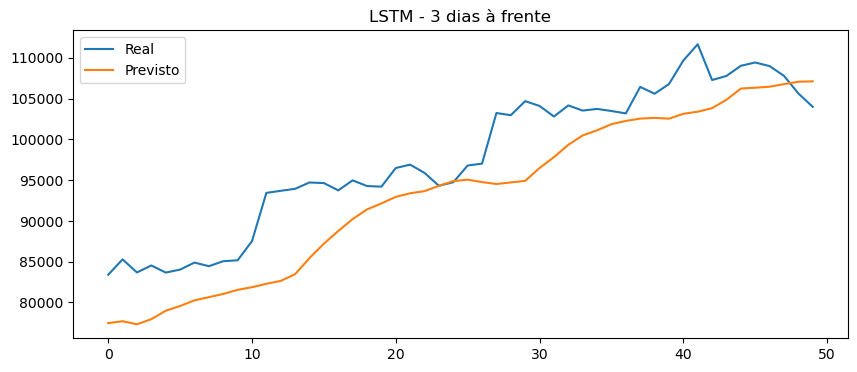

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


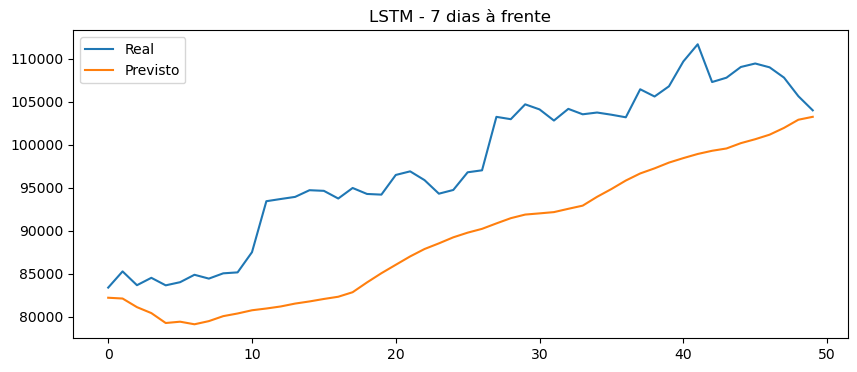

[(1,
  {'MAE': 2610.2547549616993,
   'RMSE': np.float64(3355.365593306318),
   'MAPE': np.float64(3.2619855481878983)}),
 (3,
  {'MAE': 3692.935040912256,
   'RMSE': np.float64(4682.6288247148395),
   'MAPE': np.float64(4.581201200967298)}),
 (7,
  {'MAE': 5063.590389315643,
   'RMSE': np.float64(6520.559195714213),
   'MAPE': np.float64(6.167186283437862)})]

In [12]:
# [7] Rodar LSTM multi-step
lstm_results = []

for h in horizons:
    y_test, y_pred = train_lstm(scaled, n_lags=30, horizon=h, epochs=15)

    metrics = calc_metrics(y_test, y_pred)
    lstm_results.append((h, metrics))

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test[-50:], label='Real')
    plt.plot(y_pred[-50:], label='Previsto')
    plt.title(f'LSTM - {h} dias à frente')
    plt.legend()
    plt.show()

lstm_results


In [13]:
# [8] Comparação Prophet vs LSTM
print("Resultados Prophet:")
for h, m in prophet_results:
    print(f"Horizonte {h}d -> {m}")

print("\nResultados LSTM:")
for h, m in lstm_results:
    print(f"Horizonte {h}d -> {m}")


Resultados Prophet:
Horizonte 1d -> {'MAE': 7198.381290746678, 'RMSE': np.float64(7198.381290746678), 'MAPE': np.float64(6.879312335281029)}
Horizonte 3d -> {'MAE': 7560.350390588617, 'RMSE': np.float64(7587.518354913327), 'MAPE': np.float64(7.213239857235827)}
Horizonte 7d -> {'MAE': 10824.860723365953, 'RMSE': np.float64(10994.32556620667), 'MAPE': np.float64(10.077653077511165)}

Resultados LSTM:
Horizonte 1d -> {'MAE': 2610.2547549616993, 'RMSE': np.float64(3355.365593306318), 'MAPE': np.float64(3.2619855481878983)}
Horizonte 3d -> {'MAE': 3692.935040912256, 'RMSE': np.float64(4682.6288247148395), 'MAPE': np.float64(4.581201200967298)}
Horizonte 7d -> {'MAE': 5063.590389315643, 'RMSE': np.float64(6520.559195714213), 'MAPE': np.float64(6.167186283437862)}
